In [1]:
import glob
import random
import matplotlib.pyplot as plt


def get_random_image(dir):
    folder = f"./data/chest_xray/{dir}/*.jpeg"  
    image_paths = glob.glob(folder)
    max_length = len(image_paths)
    random_number = random.randint(0, max_length)
    for index, item in enumerate(image_paths, start=1):
        if index == random_number:
            print(index,item)
            image = plt.imread(item)
            ready_image=plt.imshow(image)
            plt.show()
            return ready_image


16 ./data/chest_xray/val/val_normal4.jpeg


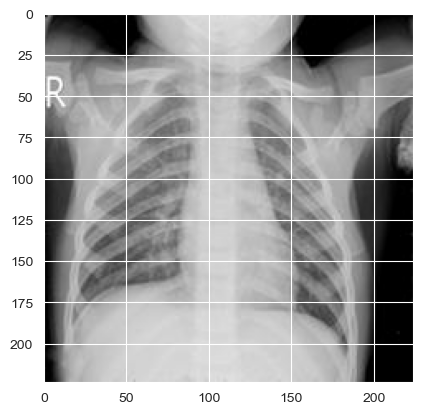

In [2]:
get_random_image("val")

In [3]:
from PIL import Image

def format_image_filenames(dir):
    folder = f"./data/chest_xray/{dir}/*/*.jpeg"
    
    counter_pneumonia = 0
    counter_normal = 0
    
    image_paths = glob.glob(folder)
    
    for img in image_paths:
        full_size_image = Image.open(img)
        image = full_size_image.resize((224,224))
        if "person" in img:
            plt.imsave(fname = f"./data/chest_xray/{dir}/train_pneumonia"+str(counter_pneumonia)+'.jpeg', arr=image,format = "jpeg", cmap = 'gray')
            counter_pneumonia+=1
        else:
            plt.imsave(fname=f"./data/chest_xray/{dir}/train_normal"+str(counter_normal)+'.jpeg', arr=image,format="jpeg", cmap='gray')
            counter_normal+=1

In [4]:
image_filenames = ['val']

for filename in image_filenames:    
    format_image_filenames(filename)

In [5]:
import pandas as pd

folder = "./data/chest_xray/*/*.jpeg"

category = []
condition_of_lung = []
filenames = []

all_files = glob.glob(folder)

for filename in all_files:
    if "train" in filename:
        category.append("train")
    elif "test" in filename:
        category.append("test")
    else:
        category.append("val")

    filenames.append(filename)

    if "pneumonia" in filename:
        condition_of_lung.append("pneumonia")
    elif "normal" in filename:
        condition_of_lung.append("normal")

all_data_df = pd.DataFrame({"dataset type":category, "x-ray result":condition_of_lung,"filename":filenames})
print(all_data_df.head())

  dataset type x-ray result                                   filename
0          val    pneumonia  ./data/chest_xray/val/val_pneumonia5.jpeg
1          val       normal     ./data/chest_xray/val/val_normal7.jpeg
2          val       normal     ./data/chest_xray/val/val_normal6.jpeg
3          val    pneumonia  ./data/chest_xray/val/val_pneumonia4.jpeg
4          val    pneumonia  ./data/chest_xray/val/val_pneumonia3.jpeg


In [6]:
print(category[0])
print(condition_of_lung[0])
print(filenames[0])

val
pneumonia
./data/chest_xray/val/val_pneumonia5.jpeg


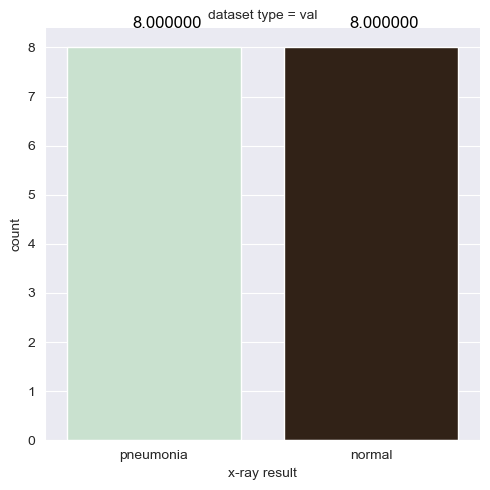

In [7]:
import seaborn as sns

bar_graph = sns.catplot(x="x-ray result",col="dataset type",kind="count",palette="ch:55",data=all_data_df,legend=True)

for i in range(0,1):
    ax = bar_graph.facet_axis(0,i)
    for p in ax.patches:
        ax.text(p.get_x()+0.3,p.get_height()*1.05,'{0:0f}'.format(p.get_height()),color="black",rotation="horizontal",size="large")

In [8]:
import os

def get_data_frame_for_ls_files(dir):
    img_folder = f'./data/chest_xray/{dir}/*.jpeg'
    df_lst = pd.DataFrame(columns=['labels','s3_path'])
    img_paths = glob.glob(img_folder)
    counter = 0
    class_arg = ''
    for image_path in img_paths:
        if "pneumonia" in image_path:
            class_arg = 1
        else:
            class_arg = 0
        df_lst.loc[counter] = [class_arg, os.path.basename(image_path)]  
        counter+=1
    return df_lst
      

In [9]:
train_df_lst = get_data_frame_for_ls_files('train')

In [10]:
test_df_lst = get_data_frame_for_ls_files("test")

In [11]:
def save_to_list(data_frame, prefix):
    return data_frame[["labels","s3_path"]].to_csv(f"{prefix}.lst",sep="\t",index=True,header=False)

In [12]:
save_to_list(train_df_lst.copy(), "train")

In [13]:
save_to_list(test_df_lst.copy(),"test")

In [14]:
bucket = 'medical-ai-pneumonia'
region = 'eu-central-1'
roleArn = 'arn:aws:s3:::medical-ai-pneumonia'

In [15]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

In [16]:
#!aws s3 sync ./data/chest_xray/train s3://${DEFAULT_S3_BUCKET}/train/
#!aws s3 sync ./data/chest_xray/test s3://${DEFAULT_S3_BUCKET}/test/


In [17]:
import boto3

boto3.Session().resource('s3').Bucket(bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(bucket).Object('test.lst').upload_file('./test.lst')

In [18]:
import sagemaker
from sagemaker import image_uris
from sagemaker import get_execution_role
session = sagemaker.Session()

algorithm_image = image_uris.retrieve(
    region=boto3.Session().region_name,
    framework="image-classification"
)

s3_output_location = f"s3://{bucket}/models/image_model"
print(algorithm_image)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/berinaspirjan/Library/Application Support/sagemaker/config.yaml
813361260812.dkr.ecr.eu-central-1.amazonaws.com/image-classification:1


In [19]:
role = get_execution_role()
print(role)

arn:aws:iam::590184007327:role/machinelearning


In [20]:
image_classifier_model = sagemaker.estimator.Estimator(
    algorithm_image,
    role=role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    volume_size=50,
    max_run=432000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=session
)

In [21]:
print(image_classifier_model)

In [22]:
counter = 0
for filepath in glob.glob("./data/chest_xray/train/*.jpeg"):
    counter+=1
print(counter)

0


In [23]:
image_classifier_model.set_hyperparameters(
    image_shape="3,244,244",
    num_classes=2,
    use_pretrained_model=1,
    num_training_samples=counter,
    augmentation_type = "crop_color_transformation",
    epochs=15,
    early_stopping = True,
    early_stopping_min_epochs = 8,
    early_stopping_patience = 5,
    early_stopping_tolerance = 0.0,
    lr_scheduler_factor = 0.1,
    lr_scheduler_step = "8,10,12"
)


In [24]:
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
    "learning_rate":ContinuousParameter(0.01,0.1),
    "mini_batch_size":CategoricalParameter([8,16,32]),
    "optimizer":CategoricalParameter(["sgn","adam"])
}

In [25]:
objective_metric_name = "validation:accuracy"
objective_type = "Maximize"
max_jobs = 5
max_parallel_jobs = 1

In [26]:
tuner = HyperparameterTuner(estimator=image_classifier_model,objective_metric_name=objective_metric_name,hyperparameter_ranges=hyperparameter_ranges,objective_type=objective_type,max_jobs=max_jobs,max_parallel_jobs=max_parallel_jobs)

In [27]:
from sagemaker.session import TrainingInput

model_inputs = {
    "train":sagemaker.inputs.TrainingInput(s3_data=f"s3://{bucket}/train/",content_type="application/x-image"),
    "validation":sagemaker.inputs.TrainingInput(s3_data=f"s3://{bucket}/test/",content_type="application/x-image"),
    "train_lst":sagemaker.inputs.TrainingInput(s3_data=f"s3://{bucket}/train.lst",content_type="application/x-image"),
    "validation_lst":sagemaker.inputs.TrainingInput(s3_data=f"s3://{bucket}/test.lst",content_type="application/x-image"),

}

In [28]:
import time
job_name_prefix = "classifier"
timestamp = time.strftime("-%y-%m-%d-%H-%M-%S",time.gmtime())
job_name = f"{job_name_prefix}-{timestamp}"

In [29]:
tuner.fit(inputs=model_inputs,job_name=job_name,logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateHyperParameterTuningJob operation: The account-level service limit 'ml.p2.xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota.

In [ ]:
model = sagemaker.model.Model(
    image_uri=algorithm_image,
    model_data=
)